In [9]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2

%matplotlib widget

import torch
torch.set_float32_matmul_precision('high')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Import the relevant modules
import numpy as np
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sousvide.synthesize.rollout_generator as rg
import sousvide.synthesize.observation_generator as og
import sousvide.control.networks.feature_extractors as fe
import sousvide.utilities.feature_utilities as fu
import figs.visualize.generate_videos as gv
import figs.utilities.transform_helper as th

In [11]:
cohort = "features"

data_method = "eval_single"
eval_method = "eval_single"

scene = "mid_gate"

courses = ["traverse"]   

roster = ["clanGhostBear"]

In [ ]:
# Generate Rollouts
rg.generate_rollout_data(cohort,courses,scene,data_method)

In [ ]:
og.generate_observation_data(cohort,roster)

In [12]:
# Load variables
vit = fe.DINOv2()
Tro,Xro,Uro,Iro = fu.extract_rollout_data(cohort,courses[0])

Using cache found in /home/admin/.cache/torch/hub/facebookresearch_dinov2_main


In [ ]:
# Extract initial patch
with torch.no_grad():
    img0 = fu.process_image(Iro[0]).unsqueeze(0)
    img5 = fu.process_image(Iro[5]).unsqueeze(0)

    pat0 = vit(img0).squeeze(0).view(16,16,-1)
    pat5 = vit(img5).squeeze(0).view(16,16,-1)

target = pat0[10,10,:]

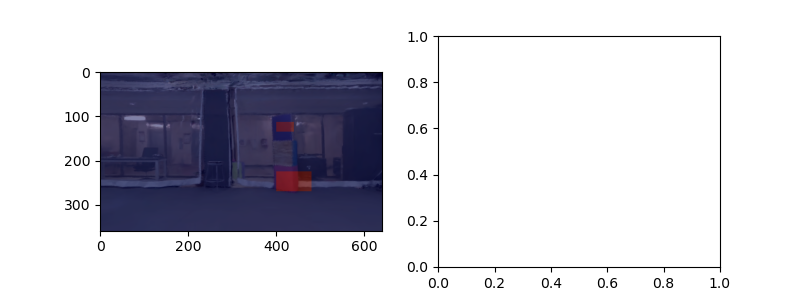

In [ ]:
cSm0 = fu.compute_similarity(target,pat0)
idxs0 = fu.get_patch_indices(cSm0)

olay0 = fu.similarity_overlay(idxs0,Iro[0])
olay5 = fu.similarity_overlay(idxs0,Iro[5])

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].imshow(overlay)

In [ ]:
idxs = np.array([
    [ 8,  8],
    [ 8, 10],
    [11,  8],
    [11, 10],])
# idxs = np.array([
#     [ 1,  8],
#     [ 0, 10],
#     [13,  8],
#     [14, 10],])
# idxs = np.array([
#     [ 3,  2],
#     [10,  2],
#     [11, 13],
#     [ 1, 12],])
Np = idxs.shape[0]

patches = []
for i in range(Np):
    patches.append(ptk1[idxs[i,0],idxs[i,1],:])

cos_sims = torch.zeros((Np,16,16))
for i in range(Np):
    for j in range(16):
        for k in range(16):
            patch2 = ptk2[j,k,:]
            cos_sims[i,j,k] = F.cosine_similarity(patches[i],patch2,dim=0)

imgs1_hots = np.zeros((16,16))
imgs2_hots = np.zeros((16,16))
for i in range(Np):
    # max_idx = torch.argmax(cos_sims[i,:,:])
    # row,col = divmod(max_idx.item(), 16)

    imgs1_hots[idxs[i,0],idxs[i,1]] = 1
    # imgs2_hots[row,col] = 1
    imgs2_hots = (cos_sims[i,:,:] > 0.6).float()

overlay1 = fu.overlay_heatmap_on_image(imgs1_hots,img1)
overlay2 = fu.overlay_heatmap_on_image(imgs2_hots,img2)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].imshow(overlay1)
axs[1].imshow(overlay2)

In [ ]:
Nro = Iro.shape[0]
height = Iro.shape[1]
width = Iro.shape[2]

Iout = np.zeros((Nro,height,width,3),dtype=np.uint8)
for p in range(Nro):
    img2 = 1*Iro[p]

    img_in2 = fu.process_image(img2).unsqueeze(0)        
    with torch.no_grad():
        ptk2 = vit(img_in2).squeeze(0).view(16,16,-1)

    cos_sims = torch.zeros((Np,16,16))
    for i in range(Np):
        for j in range(16):
            for k in range(16):
                patch2 = ptk2[j,k,:]
                cos_sims[i,j,k] = F.cosine_similarity(patches[i],patch2,dim=0)

    imgs2_hots = np.zeros((16,16))
    for i in range(Np):
        # max_idx = torch.argmax(cos_sims[i,:,:])
        # row,col = divmod(max_idx.item(), 16)

        # imgs2_hots[row,col] = 1
        imgs2_hots = (cos_sims[i,:,:] > 0.6).float()

        
    Iout[p,:,:,:] = fu.overlay_heatmap_on_image(imgs2_hots,img2)

gv.images_to_mp4(Iout,"output4.mp4",fps=20)